In [6]:
!pip install networkx matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 55.7 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 25.7 MB/s  0:00:00

   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   -------- ------------------------------- 1/5 [fonttools]
   ------------------------ --------------- 3/5 [contour

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import json
import os

In [14]:
class GraphRAG:
    def __init__(self, embed_model="sentence-transformers/all-MiniLM-L6-v2"):
        self.embedder = SentenceTransformer(embed_model)
        self.graph = nx.Graph()
        self.index = None
        self.nodes = []

    def _embed(self, text: str) -> np.ndarray:
        emb = self.embedder.encode([text], convert_to_numpy=True)
        return np.array(emb, dtype="float32")

    def add_knowledge(self, entity1: str, relation: str, entity2: str):
        """Adiciona conhecimento no grafo"""
        self.graph.add_edge(entity1, entity2, relation=relation)

        # Indexação semântica
        for ent in [entity1, entity2]:
            if ent not in self.nodes:
                emb = self._embed(ent)
                if self.index is None:
                    self.index = faiss.IndexFlatL2(emb.shape[1])
                self.index.add(emb)
                self.nodes.append(ent)

    def plot_graph(self):
        """Plota o grafo com matplotlib"""
        pos = nx.spring_layout(self.graph, seed=42)  # layout fixo

        # Nós
        nx.draw_networkx_nodes(self.graph, pos, node_color="lightblue", node_size=2000)

        # Arestas
        nx.draw_networkx_edges(self.graph, pos, edge_color="gray")

        # Labels dos nós
        nx.draw_networkx_labels(self.graph, pos, font_size=10, font_weight="bold")

        # Labels das arestas (relações)
        edge_labels = nx.get_edge_attributes(self.graph, "relation")
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_color="red")

        plt.title("GraphRAG - Relações entre entidades")
        plt.axis("off")
        plt.show()


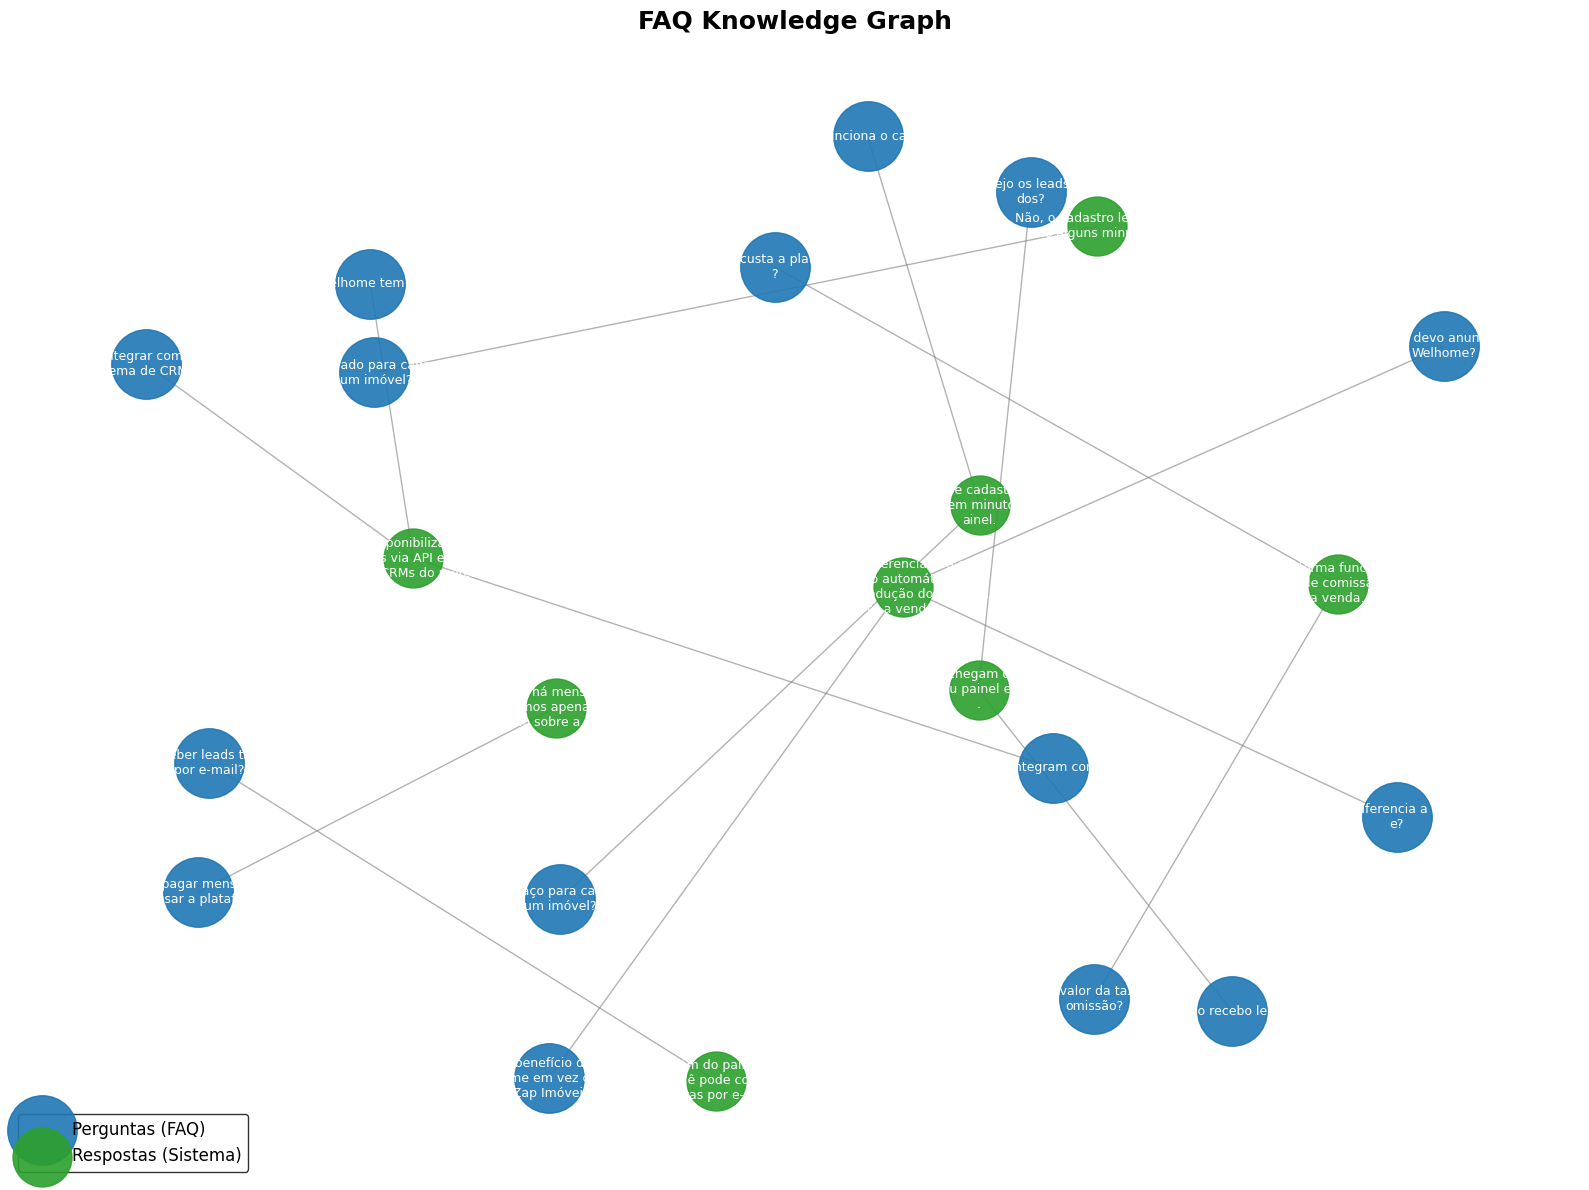

In [16]:
def build_graph_from_faq(json_path: str):
    # Carregar FAQ
    with open(json_path, "r", encoding="utf-8") as f:
        faq_data = json.load(f)

    G = nx.Graph()

    for item in faq_data:
        q = item["q"]
        a = item["a"]

        # Criar aresta simples (Pergunta -> Resposta)
        G.add_node(q, type="pergunta")
        G.add_node(a, type="resposta")
        G.add_edge(q, a, relation="responde")

    return G


def plot_graph(G):
    pos = nx.spring_layout(G, seed=42, k=1.2)

    perguntas = [n for n, d in G.nodes(data=True) if d["type"] == "pergunta"]
    respostas = [n for n, d in G.nodes(data=True) if d["type"] == "resposta"]

    plt.figure(figsize=(16, 12))

    nx.draw_networkx_nodes(G, pos, nodelist=perguntas,
                           node_color="#1f77b4", node_size=2500,
                           alpha=0.9, label="Perguntas (FAQ)")

    nx.draw_networkx_nodes(G, pos, nodelist=respostas,
                           node_color="#2ca02c", node_size=1800,
                           alpha=0.9, label="Respostas (Sistema)")

    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.6)

    labels = {n: "\n".join(n[i:i+25] for i in range(0, len(n), 25)) for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_color="white")

    plt.title("FAQ Knowledge Graph", fontsize=18, fontweight="bold")

    # Legenda ajustada (fora do grafo, canto inferior esquerdo)
    plt.legend(scatterpoints=1, fontsize=12, loc="lower left",
               frameon=True, facecolor="white", edgecolor="black")

    plt.axis("off")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Caminho absoluto para o faq.json
    json_path = r"C:\Users\rafae.RAFAEL_NOTEBOOK\Downloads\case_cd_welhome\py\faq.json"
    G = build_graph_from_faq(json_path)
    plot_graph(G)